### 무신사 리뷰 NLP

**라이브러리 불러오기**

In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
#from selenium import webdriver
import pandas as pd
from tqdm.notebook import tqdm
import time, urllib
#from selenium import webdriver
#from selenium.webdriver.common.keys import Keys
import numpy as np;import re, os, sys, json

from pykospacing import Spacing #띄어쓰기
spacing=Spacing()
from konlpy.tag import Kkma #형태소분석
from konlpy.tag import Okt #형태소분석
import soynlp; from soynlp.normalizer import * #정규화
from hanspell import spell_checker #맞춤법
from konlpy.tag import Komoran, Hannanum, Kkma, Okt
#komoran = Komoran(); hannanum = Hannanum(); kkma = Kkma(); okt = Okt()

- 설치

In [8]:
#pip install git+https://github.com/haven-jeon/PyKoSpacing.git
#!pip install py-hanspell
#!pip install PyKomoran

**데이터 불러오기**

In [3]:
#최종파일_Page1to20 #총 35,752개 관측치
df = pd.read_csv("data/hood_page1to20_final_nodup.csv", encoding='utf-8')
df.shape

(35752, 18)

In [5]:
#df.info()
df.isnull().sum()

Unnamed: 0         0
user               0
gender          2402
height          2402
weight          2402
item               0
size               0
star               0
content            0
size_eval        569
bright_eval      569
color_eval       569
thick_eval       569
cm             13847
총장             13847
어깨너비           14867
가슴단면           13847
소매길이           13954
dtype: int64

- 총 35,752개의 리뷰, 18개의 컬럼
- 리뷰 결측치는 존재하지 않음
- 리뷰 자체만으로 중복 제거하면 32,244개로 줄어듬!

In [6]:
df['content'].drop_duplicates(inplace=False).shape

(32244,)

- 리뷰 중복되는 관측치들이 여러개, 뜯어보기

In [3]:
#리뷰가 중복되는 관측치들만 뽑아내기
df_dup = df.iloc[df.duplicated(subset=['content'], keep=False).values,:]

In [45]:
#(1)기본정보(성별, 키, 몸무게) 다르고, 구매한 상품도 다르지만 리뷰가 똑같음
df_dup.iloc[(df_dup['content']==df_dup['content'].value_counts().index[0]).values, :]

,Unnamed: 0,user,gender,height,weight,item,size,star,content,size_eval,bright_eval,color_eval,thick_eval,cm,총장,어깨너비,가슴단면,소매길이
227,227,LV 8 이기홍,여성,153cm,50kg,THIRD LOGO HOODIE CHARCOAL(MG2BSMM430A),차콜/기모 XL,5.0,좋아요. 가격도 괜찮고 너무 예쁘네요 고민하시는분들 추천드려요,보통이에요,보통이에요,보통이에요,보통이에요,NaN,NaN,NaN,NaN,NaN
264,264,LV 8 이기홍,여성,165cm,70kg,THIRD LOGO HOODIE BLACK(MG2BSMM430A),블랙/기모 S,5.0,좋아요. 가격도 괜찮고 너무 예쁘네요 고민하시는분들 추천드려요,보통이에요,보통이에요,보통이에요,보통이에요,NaN,NaN,NaN,NaN,NaN
269,269,LV 8 이기홍,NaN,NaN,NaN,THIRD LOGO HOODIE GREY(MG2BSMM430A),그레이/기모 M,5.0,좋아요. 가격도 괜찮고 너무 예쁘네요 고민하시는분들 추천드려요,보통이에요,보통이에요,보통이에요,보통이에요,NaN,NaN,NaN,NaN,NaN
290,290,LV 8 이기홍,여성,153cm,50kg,THIRD LOGO HOODIE BLUE(MG2BSMM430A),블루/논기모 M,5.0,좋아요. 가격도 괜찮고 너무 예쁘네요 고민하시는분들 추천드려요,보통이에요,보통이에요,보통이에요,보통이에요,NaN,NaN,NaN,NaN,NaN
3207,3508,LV 8 이기홍,NaN,NaN,NaN,LOCATION HOODIE [BLACK],S,5.0,좋아요. 가격도 괜찮고 너무 예쁘네요 고민하시는분들 추천드려요,보통이에요,보통이에요,보통이에요,보통이에요,S,68.0,63.0,57.0,55.5
3247,3548,LV 8 이기홍,여성,153cm,50kg,LOCATION HOODIE [IVORY],M,5.0,좋아요. 가격도 괜찮고 너무 예쁘네요 고민하시는분들 추천드려요,보통이에요,보통이에요,보통이에요,보통이에요,M,69.5,64.5,59.5,56.5
7276,9765,LV 8 이기홍,여성,153cm,50kg,Arch Logo Hoodie Navy,M,5.0,좋아요. 가격도 괜찮고 너무 예쁘네요 고민하시는분들 추천드려요,보통이에요,보통이에요,보통이에요,보통이에요,M,70.0,53.5,59.5,63.5
8077,10715,LV 8 이기홍,여성,153cm,50kg,잇 저스트 마이 후디[블랙],M_기모,5.0,좋아요. 가격도 괜찮고 너무 예쁘네요 고민하시는분들 추천드려요,보통이에요,보통이에요,보통이에요,보통이에요,M_기모,73.5,61.0,65.0,72.0
8096,10734,LV 8 이기홍,여성,157cm,48kg,잇 저스트 마이 후디[블랙],L_기모,5.0,좋아요. 가격도 괜찮고 너무 예쁘네요 고민하시는분들 추천드려요,보통이에요,보통이에요,보통이에요,보통이에요,L_기모,75.5,62.5,67.0,74.0
18046,23563,LV 8 이기홍,남성,175cm,70kg,LOCATION HOODIE [LIGHT PURPLE],XL,5.0,좋아요. 가격도 괜찮고 너무 예쁘네요 고민하시는분들 추천드려요,보통이에요,보통이에요,보통이에요,보통이에요,XL,74.5,67.5,64.5,58.5


In [46]:
#(2)여러개의 상품, 사이즈를 샀지만 리뷰는 전부 똑같음
df_dup.iloc[(df_dup['content']==df_dup['content'].value_counts().index[1]).values, :]

,Unnamed: 0,user,gender,height,weight,item,size,star,content,size_eval,bright_eval,color_eval,thick_eval,cm,총장,어깨너비,가슴단면,소매길이
2486,2605,LV 8 모두의므신사,남성,174cm,62kg,베이직 기모 후드티 블랙,XL,5.0,어떻게 코디를 하든지간에 무난하게 어울리고 착용하기에 편해서 좋은 것 같습니다,커요,보통이에요,보통이에요,보통이에요,XL,72.0,54.0,60.0,66.0
3369,3769,LV 8 모두의므신사,남성,174cm,62kg,[기모] mmM 일러스트 타투 후드 헤비오버핏 그레이,노기모M,5.0,어떻게 코디를 하든지간에 무난하게 어울리고 착용하기에 편해서 좋은 것 같습니다,보통이에요,보통이에요,보통이에요,보통이에요,NaN,NaN,NaN,NaN,NaN
6709,8953,LV 8 모두의므신사,남성,174cm,62kg,[패키지] NYC LOCATION HOOD T-SHIRTS (13COLOR) [LR...,차콜/L ...,5.0,어떻게 코디를 하든지간에 무난하게 어울리고 착용하기에 편해서 좋은 것 같습니다,커요,보통이에요,보통이에요,보통이에요,NaN,NaN,NaN,NaN,NaN
13092,17833,LV 8 모두의므신사,남성,174cm,62kg,VARSITY LOGO HOODIE GREY(MG2CSMM406A),그레이/논기모 M,5.0,어떻게 코디를 하든지간에 무난하게 어울리고 착용하기에 편해서 좋은 것 같습니다,보통이에요,보통이에요,보통이에요,보통이에요,NaN,NaN,NaN,NaN,NaN
27432,34095,LV 8 모두의므신사,남성,174cm,62kg,Sweet Home Pullover Hood - Black,L,5.0,어떻게 코디를 하든지간에 무난하게 어울리고 착용하기에 편해서 좋은 것 같습니다,커요,보통이에요,보통이에요,보통이에요,L,69.0,60.5,62.0,61.0
29036,35756,LV 8 모두의므신사,남성,174cm,62kg,CEREMONY LAUREL HOODIE_BLACK,M,5.0,어떻게 코디를 하든지간에 무난하게 어울리고 착용하기에 편해서 좋은 것 같습니다,보통이에요,보통이에요,보통이에요,보통이에요,M,66.0,55.0,58.0,58.0
30194,37019,LV 8 모두의므신사,남성,174cm,62kg,LMC OG HOODIE charcoal,S,5.0,어떻게 코디를 하든지간에 무난하게 어울리고 착용하기에 편해서 좋은 것 같습니다,보통이에요,보통이에요,보통이에요,보통이에요,S,64.0,53.0,60.0,61.0
30195,37020,LV 8 모두의므신사,남성,174cm,62kg,LMC OG HOODIE charcoal,XL,5.0,어떻게 코디를 하든지간에 무난하게 어울리고 착용하기에 편해서 좋은 것 같습니다,커요,보통이에요,보통이에요,보통이에요,XL,71.0,59.0,67.0,66.0
33443,40352,LV 8 모두의므신사,남성,174cm,62kg,IK 스튜디오 후디 라이트그레이(IK2CFMM420A),라이트그레이/L,5.0,어떻게 코디를 하든지간에 무난하게 어울리고 착용하기에 편해서 좋은 것 같습니다,커요,보통이에요,보통이에요,보통이에요,NaN,NaN,NaN,NaN,NaN
35523,42559,LV 8 모두의므신사,남성,174cm,62kg,Indians Hood T-shirts_Melange grey [LHQSCTH352...,M,5.0,어떻게 코디를 하든지간에 무난하게 어울리고 착용하기에 편해서 좋은 것 같습니다,보통이에요,보통이에요,보통이에요,보통이에요,M,71.0,62.0,60.0,59.0


In [47]:
#(3)기본정보는 같음(동일한사람이 구매), 구매한 사이즈/상품/평가는 다르지만 리뷰는 같음
df_dup.iloc[(df_dup['content']==df_dup['content'].value_counts().index[2]).values, :]

,Unnamed: 0,user,gender,height,weight,item,size,star,content,size_eval,bright_eval,color_eval,thick_eval,cm,총장,어깨너비,가슴단면,소매길이
7101,9490,LV 4 사니 0_0,남성,168cm,58kg,미시간 울버린 피그먼트 후드티 블랙 차콜,[NO기모]LARGE,5.0,색깔이 너무 맘에들고 제가 원하던 핏이 딱 떨어져서 너무나 마음에 듭니다 휘뚜루 마...,보통이에요,보통이에요,선명해요,보통이에요,[NO기모]LARGE,73.0,64.0,62.0,58.0
7432,9996,LV 4 사니 0_0,남성,168cm,58kg,TAG HOODIE - ASH,L(기모 / green),5.0,색깔이 너무 맘에들고 제가 원하던 핏이 딱 떨어져서 너무나 마음에 듭니다 휘뚜루 마...,보통이에요,밝아요,선명해요,두꺼워요,NaN,NaN,NaN,NaN,NaN
8969,11690,LV 4 사니 0_0,남성,168cm,58kg,베츠 어센틱 후드 그레이,L,5.0,색깔이 너무 맘에들고 제가 원하던 핏이 딱 떨어져서 너무나 마음에 듭니다 휘뚜루 마...,보통이에요,밝아요,선명해요,보통이에요,L,70.0,59.0,60.0,59.0
9178,12082,LV 4 사니 0_0,남성,168cm,58kg,TAG HOODIE - ASH,L(기모 / green),5.0,색깔이 너무 맘에들고 제가 원하던 핏이 딱 떨어져서 너무나 마음에 듭니다 휘뚜루 마...,보통이에요,밝아요,선명해요,두꺼워요,L(기모 / green),71.0,58.0,63.5,60.0
19387,25186,LV 4 사니 0_0,남성,168cm,58kg,베츠 어센틱 후드 그레이,L,5.0,색깔이 너무 맘에들고 제가 원하던 핏이 딱 떨어져서 너무나 마음에 듭니다 휘뚜루 마...,보통이에요,밝아요,선명해요,보통이에요,L,70.0,60.0,62.0,61.0
21205,27221,LV 4 사니 0_0,남성,168cm,58kg,EarthHeart 후드티,제트블랙/XL,5.0,색깔이 너무 맘에들고 제가 원하던 핏이 딱 떨어져서 너무나 마음에 듭니다 휘뚜루 마...,보통이에요,어두워요,선명해요,두꺼워요,NaN,NaN,NaN,NaN,NaN
21695,27711,LV 4 사니 0_0,남성,168cm,58kg,미시간 울버린 피그먼트 후드티 블랙 차콜,[NO기모]LARGE,5.0,색깔이 너무 맘에들고 제가 원하던 핏이 딱 떨어져서 너무나 마음에 듭니다 휘뚜루 마...,보통이에요,보통이에요,선명해요,보통이에요,NaN,NaN,NaN,NaN,NaN


### 단어 사전 구축</span>

- 리뷰 중복 제거 후 | 32,244개</span>

In [7]:
dfno = df.drop_duplicates(subset=['content'])
(dfno['content'].value_counts()>=2).sum() #dfno 데이터에 동일한 리뷰가 존재하지 않음

0

In [8]:
dfno.shape

(32244, 18)

In [9]:
dfno.drop_duplicates(subset = None,keep = 'first', inplace = True,ignore_index = True)
print('중복제거df : ', dfno.shape)#전체열이 같은 중복제거

중복제거df :  (32244, 18)


<ipython-input-9-1e2cc2b90ccb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfno.drop_duplicates(subset = None,keep = 'first', inplace = True,ignore_index = True)


In [10]:
#성별, 키,몸무게 모두 null아니고 수치종류 적어도 하나 값이 있는 것들 filter
dfno = dfno[~dfno['gender'].isnull()&~dfno['height'].isnull()&~dfno['weight'].isnull()&
                                      (~dfno['총장'].isnull()|
                                       ~dfno['어깨너비'].isnull()|~dfno['가슴단면'].isnull()|
                                       ~dfno['소매길이'].isnull())]
print('최종사용 data:{}'.format(dfno.shape))
print('-'*10)

최종사용 data:(18237, 18)
----------


---

- 외국어리뷰 분석</span>
- 단 9개만 존재 - 거의 0.03% - 삭제

In [179]:
dfno.reset_index(drop=True, inplace=True)

i = 0; nohangul = []
for i in range(dfno.shape[0]):
    text = re.sub('[^ㄱ-ㅣ가-힣]', '',dfno.iloc[i,8])
    if(text==''):
        nohangul.append(i)
#한글이 단 한글자도 존재하지 않는 리뷰는 총 9개
dfno.iloc[nohangul, 8]

4698     I bought an M size instead of the S size and i...
6647                  the price is aforttable good quality
13978                               very good 真的非常好看纯纯纸片人呢
14256                                Gooabcdefghi.jklmnopd
14862    The size is perfect. Quality feels really good...
22117                        This clothes is very awesome.
23706                               颜色好看，好搭配衣服，价格非常实惠，爱了❤️
25565    Good product price good product good price goo...
27088    Good quality and color is very pretty.Size is ...
Name: content, dtype: object

In [28]:
dfno['content'][5]

'캐릭터 넘 귀엽고 기모도 진짜 따뜻따듯 보들보들해서 기분 좋아요 s 샀는데 약간 큰 것 같긴 한데 그래도 캐릭터가 넘 귀여워서 오버핏으로 입으니까 더 깜찍해보여용 추천합니당'

- 영어 단어 빈도수 확인</span>
- 총 4509개 중에서 사이즈 관련된 단어(xs, s, m 등)만 4017개

In [191]:
dfno = dfno.iloc[[True if i not in nohangul else False for i in range(dfno.shape[0])],:]
dfno.reset_index(drop=True, inplace=True)
dfno.shape

(32235, 19)

In [197]:
rvv = [] 
rv = dfno['content'].values.tolist()
for i in rv:
    text = re.sub('[^a-zA-Z]',' ',i).strip() 
    #영어/숫자 제외 공백 대체(그냥 제거하면 한 리뷰 안에 여러개를 구분 못함)
    text = text.lower() #모두 소문자로 변경
    if (text != ''):
        rvv.append(text) #영어/숫자가 존재했던 리뷰만 담기
        
rvvv = []
for i in range(len(rvv)):
    rvvv.append(rvv[i].split(' '))
    #기존 공백은 ''으로 분리됨
rvvv = np.concatenate(rvvv).tolist() #리스트 차원 낮추기

eng_rv = []
for j in range(len(rvvv)):
    if rvvv[j] != '':
        eng_rv.append(rvvv[j])
eng_rv = pd.DataFrame({'eng_rv':eng_rv})

In [202]:
eng_rv['eng_rv'].value_counts().head(50)
eng_rv['eng_rv'].value_counts().tail(50)

print('전체 단어 : ', eng_rv.shape[0], '개')
print('고빈도 단어(사이즈 관련) : ', 1522+939+854+501+33+18, '개')

전체 단어 :  4432 개
고빈도 단어(사이즈 관련) :  3867 개


- 전처리 진행</span>

In [461]:
spacing = Spacing()
#데이터 재로드
df = pd.read_csv("hood_page1to20_final_nodup.csv", encoding='utf-8')
dfno = df.drop_duplicates(subset=['content'])
dfno.reset_index(drop=True, inplace=True)

dfno['review'] = str('')
#외국어 리뷰 삭제
i = 0; nohangul = []
for i in range(dfno.shape[0]):
    text = re.sub('[^ㄱ-ㅣ가-힣]', '',dfno.iloc[i,8])
    if(text==''):
        nohangul.append(i)
dfno = dfno.iloc[[True if i not in nohangul else False for i in range(dfno.shape[0])],:]
dfno.reset_index(drop=True, inplace=True)

#이후 전처리
i=0
for i in range(dfno.shape[0]):
    text = dfno.iloc[i,8]
    text = re.sub(pattern='[^\w\s\n]', repl='', string=text) #특수문자 제거
    text = re.sub(pattern='[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z]', repl=' ', string=text) #숫자, 그이외 삭제
    text = re.sub(pattern='[ㄱ-ㅎㅏ-ㅣ]+', repl='', string=text) #단순 모음, 자음 삭제
    text = repeat_normalize(text, num_repeats=2) #불필요반복문자정규화
    #text = spacing(text) #띄어쓰기
    dfno['review'][i] = text
print('완료')

<ipython-input-461-24ff37bbe331>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfno['review'] = str('')
<ipython-input-461-24ff37bbe331>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfno['review'][i] = text


완료


In [462]:
dfno[['content','review']].head(10)

,content,review
0,기모인데도 불구하고 값싸게 사서 좋았어유일부로 크게 샀고 만족하면서 입슴다,기모인데도 불구하고 값싸게 사서 좋았어유일부로 크게 샀고 만족하면서 입슴다
1,오버핏느낌으로 입어야 하고 기모라 따뜻햐서 좋아요,오버핏느낌으로 입어야 하고 기모라 따뜻햐서 좋아요
2,일단 귀엽고 밑단이 안 쪼여지는 거라 레이어드는 쪼끔 힘듭니다.폼도 엄청 커요,일단 귀엽고 밑단이 안 쪼여지는 거라 레이어드는 쪼끔 힘듭니다폼도 엄청 커요
3,손목에 실밥도 같이왔어요 애완 실로 키워야겠어요,손목에 실밥도 같이왔어요 애완 실로 키워야겠어요
4,후드티 핏 완전 아방해서 귀여워요 제 최애 후드티… 🫶🏻,후드티 핏 완전 아방해서 귀여워요 제 최애 후드티
5,캐릭터 넘 귀엽고 기모도 진짜 따뜻따듯 보들보들해서 기분 좋아요 s 샀는데 약간 큰...,캐릭터 넘 귀엽고 기모도 진짜 따뜻따듯 보들보들해서 기분 좋아요 s 샀는데 약간 큰...
6,기모 있어서 동글동글 따뜻하고 예뻐요앞에 주머니가 생각보다 조금 작아서 오잉 했어요,기모 있어서 동글동글 따뜻하고 예뻐요앞에 주머니가 생각보다 조금 작아서 오잉 했어요
7,사이즈는 엄청 크네요근데 어디 하나만 길거나 큰게 아니라서 핏이 적당해요기모도 두꺼...,사이즈는 엄청 크네요근데 어디 하나만 길거나 큰게 아니라서 핏이 적당해요기모도 두꺼...
8,색감 굉장히 쨍해서 마라탕 먹을 때 조심해야 합니다,색감 굉장히 쨍해서 마라탕 먹을 때 조심해야 합니다
9,너무 커요입으면 완전 힙해져요옷한테 잡아먹히기 직전이지만 그래서 편해요,너무 커요입으면 완전 힙해져요옷한테 잡아먹히기 직전이지만 그래서 편해요


- 띄어쓰기와 맞춤법</span>

In [87]:
spacing = Spacing()
for i in dfno['review'].index:
    text = dfno['review'][i]
    text = spell_checker.check(spacing(text)).as_dict()['checked']
    #text = spacing(spell_checker.check(text).as_dict()['checked'])
    dfno['review'][i] = text
dfno['review'].head()

1/1 [==============================] - 0s 144ms/step


<ipython-input-87-34c088236a32>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfno['review'][i] = text


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 193ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 72ms/step


0    기모인데도 불구하고 값싸게 사서 좋았어 유일 부론 크게 샀고 만족하면서 입습니다
1                   오버핏 느낌으로 입어야 하고 기 모라 따뜻해서 좋아요
2     일단 귀엽고 밑단이 안 쪼여지는 거라 레이어드는 쪼끔 힘듭니다 폼도 엄청 커요
3                     손목에 실밥도 같이 왔어요 애완 실로 키워야겠어요
4                    후드 티 핏 정말 아방해서 귀여워요 제 최애 후드티
Name: review, dtype: object

In [88]:
#spell_spacing = dfno['review']
spacing_spell = dfno['review']
spacing_spell.to_csv('spacing_spell.csv', encoding='utf-8')

- 여기까지 단순 전처리
1. 원본리뷰/띄어쓰기/띄어쓰기후맞춤법/맞춤법후띄어쓰기
2. 토큰화 후 빈도수 체크
3. 고빈도 단어부터 (사이즈 관련 단어) 추출
4. 총장/어깨/소매/전체로 세분화

In [463]:
#원본 : df['review'], 단순띄어쓰기 : only_spacing, 띄어쓰기후맞춤법 : spacing_spell, 맞춤법후띄어쓰기 spell_spacing
only_spacing = pd.read_csv('only_spacing.csv', encoding='utf-8')
spacing_spell = pd.read_csv('spacing_spell.csv', encoding='utf-8')
spell_spacing = pd.read_csv('spell_spacing.csv', encoding='utf-8')
df = pd.DataFrame({'original':dfno['review'], 'only_spacing': only_spacing['only_spacing'],
                   'spacing_spell':spacing_spell['review'].values, 'spell_spacing':spell_spacing['review'].values})
df.head()

,original,only_spacing,spacing_spell,spell_spacing
0,기모인데도 불구하고 값싸게 사서 좋았어유일부로 크게 샀고 만족하면서 입슴다,기모인데도 불구하고 값 싸게 사서 좋았어 유일부로 크게 샀고 만족하면서 입슴다,기모인데도 불구하고 값싸게 사서 좋았어 유일 부론 크게 샀고 만족하면서 입습니다,기모인데도 불구하고 값 싸게 사서 좋았어 에 일부로 크게 샀고 만족하면서 입습니다
1,오버핏느낌으로 입어야 하고 기모라 따뜻햐서 좋아요,오버핏 느낌으로 입어야 하고 기 모라 따뜻햐서 좋아요,오버핏 느낌으로 입어야 하고 기 모라 따뜻해서 좋아요,오버핏 느낌으로 입어야 하고 기 모라 따뜻해서 좋아요
2,일단 귀엽고 밑단이 안 쪼여지는 거라 레이어드는 쪼끔 힘듭니다폼도 엄청 커요,일단 귀엽고 밑단이 안 쪼여지는 거라 레이어드는 쪼끔 힘듭니다폼도 엄청 커요,일단 귀엽고 밑단이 안 쪼여지는 거라 레이어드는 쪼끔 힘듭니다 폼도 엄청 커요,일단 귀엽고 밑단이 안 쪼여지는 거라 레이어드는 쪼끔 힘듭니 다 폼도 엄청 커요
3,손목에 실밥도 같이왔어요 애완 실로 키워야겠어요,손목에 실밥도 같이 왔어요 애완 실로 키워야겠어요,손목에 실밥도 같이 왔어요 애완 실로 키워야겠어요,손목에 실밥도 같이 왔어요 애완 실로 키워야겠어요
4,후드티 핏 완전 아방해서 귀여워요 제 최애 후드티,후드 티 핏 완전 아방해서 귀여워요 제 최애 후드티,후드 티 핏 정말 아방해서 귀여워요 제 최애 후드티,후드 티 핏 정말 아방해서 귀여워요 제 최애 후드 티


#### 워드클라우드 생성

In [3]:
k = pd.read_csv('data/yongon_okt_only_spacing.csv', encoding='utf-8')
kk = pd.read_csv('data/chaeon_okt_only_spacing.csv', encoding='utf-8')

In [5]:
#사용할 라이브러리 불러오기
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Okt
from PIL import Image
import numpy as np

In [15]:
class SimpleGroupedColorFunc(object):
    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)
    
#워드클라우드를 그리고, 위에 simplegroupecolorfunc 덮기

NameError: name 'color_to_words' is not defined

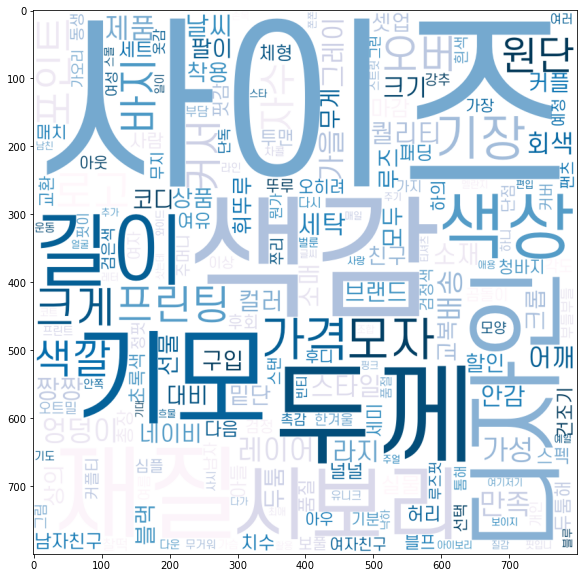

In [52]:
words = pd.read_csv('data/chaeon_okt_only_spacing.csv', encoding='utf-8')
words = words['chaeon_okt'].values.tolist()
words = [n for n in words if len(n)>1]
words = [n for n in words if n not in ['좋아요','같아요','입고','입니다','생각',
                                        '같아','진짜','후드','마음','구매','조금',
                                        '완전','겨울','느낌','추천','약간',
                                        '살짝','아주','자주','정말','무난',
                                        '그냥','듭니','사진','걱정','때문','별로','항상','이번','전체','아무','역시',
                                        '쁘네','색도','뻐용','사서','사고','참고','디테','일리','보고','매우','모라',
                                        '바로','다만','요즘','다른','주문','이건','그대로','제일','통해','계속','두운','화면',
                                        '일단','아이','기준','굿굿','하나','기본','무엇','어디','모도','자체','편이',
                                        '먼지','거의','아래','보통','평소','해도','여기','일부러','부분','드네','지금',
                                        '수도','사도','보이','일반','모로','나름','처리','시한','려고','에스','지도','대로',
                                        '최고','실제','만큼','사면','정도','고민','처음','무조건',
                                        '질도','후기','드하','원래','오버핏','이','오버핏','버핏']]
words = ['시보리' if n=='보리' else n for n in words]
c = Counter(words)
wc = WordCloud(font_path='C:/Users/user/AppData/Local/Microsoft/Windows/Fonts/SCDream4.otf', width=400, height=400, scale=2.0, 
               max_font_size=250, background_color='white', colormap ='PuBu')
gen = wc.generate_from_frequencies(c)
plt.figure(figsize=(10,10))
plt.imshow(gen)

simple_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=simple_color_func)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### <span style='background-color:#dcffe4'>토큰화 및 형태소 분석</span>

- 형태소 분석기
    - Komoran : 여러 어절을 하나의 품사로 분석가능해 고유명사 분류에 더 좋은 성능
    - Okt
    - Kkma(보류)
    - Hannanum(보류)
    - Mecab(보류)

In [29]:
#분석기별 품사정리 #[분석기.tagset]으로 품사 태깅 확인 가능
#komoran
chaeon_komoran_pos = ['NNG','NNP','NNB','NN','NP','NF','NA']; yongon_komoran_pos = ['NV','VV','VA','VX','VCP','VCN','VC'];
gwan_komoran_pos = ['MM']; busa_komoran_pos = ['MA','MAG','MAJ']
chaeon_komoran, yongon_komoran, gwan_komoran, busa_komoran = [],[],[],[]

#kkma
chaeon_kkma_pos = ['NNG','NNP','NNB','NNM','NR','NP','NN','NX','UM','NU','N']
yongon_kkma_pos = ['VV','VA','VX','VCP','VCN','AJ','AX','CP','V','VXV','VXA']
gwan_kkma_pos = ['MM','DT','DN','M','MD','MDT','MDN']; busa_kkma_pos = ['MAG','MAJ','AD','M','MA','MAG','MAC']
chaeon_kkma, yongon_kkma, gwan_kkma, busa_kkma = [],[],[],[]

#okt
chaeon_okt_pos = ['Noun','Unknown']; yongon_okt_pos = ['Adjective','Verb']
gwan_okt_pos = ['Determiner']; busa_okt_pos = ['Adverb']
chaeon_okt, yongon_okt, gwan_okt, busa_okt = [],[],[],[]

#hannanum
chaeon_hannanum_pos = ['N','NB','NC','NN','NP','NQ']; yongon_hannanum_pos = ['P','PA','PV','PX']
gwan_hannanum_pos = ['M','MM']; busa_hannanum_pos = ['M','MA']
chaeon_hannanum, yongon_hannanum, gwan_hannanum, busa_hannanum = [],[],[],[]

#mecab
chaeon_mecab_pos = ['NNB', 'NNBC', 'NNP', 'NNG', 'NP', 'NR']; yongon_mecab_pos = ['VV', 'VA', 'VX', 'VCP', 'VCN'];
gwan_mecab_pos = ['MM']; busa_mecab_pos = ['MAG','MAJ']

- <span style='background-color:#fff5b1'>Komoran 형태소 분석 결과</span>

In [31]:
for i in df['only_spacing']:
    text_komoran = komoran.pos(i)
    for one in range(len(text_komoran)):
        if(text_komoran[one][1]) in chaeon_komoran_pos:
            chaeon_komoran.append(text_komoran[one][0])
        elif(text_komoran[one][1]) in yongon_komoran_pos:
            yongon_komoran.append(text_komoran[one][0])
        elif(text_komoran[one][1]) in gwan_komoran_pos:
            gwan_komoran.append(text_komoran[one][0])
        elif(text_komoran[one][1]) in busa_komoran_pos:
            busa_komoran.append(text_komoran[one][0])
        else:
            pass

In [174]:
pd.DataFrame(chaeon_komoran).value_counts().head(50)
one = pd.DataFrame(pd.DataFrame(chaeon_komoran).value_counts()[(pd.DataFrame(chaeon_komoran).value_counts().values<=5)])
one.columns = ['counts']
two = one.reset_index(drop=False, inplace=False)
two.columns = ['text','counts']

tf = [True if len(two['text'][i])!=1 else False for i in range(two.shape[0])]
three = two.iloc[tf, :]

In [592]:
size_komoran = ['사이즈','후드','옷','티','핏도','느낌','핏이','기장','핏','오버핏으로','오버','오버핏','키','바지','길','커서',
                '길이','배','엉덩이','크기','박','널','오버핏이라','핏은','여유','루즈','체형','맨투맨','허리','치수','총장',
                '오버핏이','아래','하의','상의','몸','팬츠','덩치','낭','핏으로','오버핏은','핏이에','가슴','핏입니다','손목',
                '티셔츠','실루엣','목이','쫀쫀해서','오버핏입니다','다리','핏에','루즈핏으로','핏이고','몸통','핏을','쫀쫀하고',
                '오버핏인데','오버핏이라서','핏이라서','골반','정핏','요핏도','미디움','오버핏도','신체','등판','오버핏이여서',
                '미니','빅','조끼','쫀쫀한','핏이네요','무릎','핏인','루즈핏이','가오리핏','가로','슬림','루즈핏이라','핏하게',
                '오버핏하게','핏의','핏이어서','너비','오버핏의','후드핏','좋아요핏도','오버핏이긴','핏이여서','탑','크롭해서',
                '넥라인','모자핏이','아랫단','정핏이라','피지컬','정상','적당','앞쪽','쫀쫀하니','핏이었어요','목도','쫀쫀해요',
                '아랫부분','정핏이','앞부분','옷핏이','엠사이즈','요핏이','오버핏으로도','넓이','미듐이','긴팔','가슴팍','옆구리',
                '장감','정핏이네요','핏감은','쫀쫀하지','오버핏이구요','핏되는','단면','핏인데','의류','핏부터','요핏은','오버핏보다',
                '루즈핏에','볼륨','마르고','오버핏과','오버핏만','요핏','요팔','오버핏이예요','몸매','박시핏','미듐으로','크롭은',
                '쫀쫀',    '오바핏','정핏이에','미듐도','미디움으로','덮습니','크롭하긴','루즈핏이네요',
                
                '크','맞','길','괜찮','작','짧','아쉽','떨어지','덮','접','넓','끌','좁','쪼','알맞','흘러내리','달라붙','올라오',
                '내려가','짧아지','덮이','커다랗']

- <span style='background-color:#fff5b1'>Okt 형태소 분석 결과</span>

In [417]:
size_okt = ['사이즈','핏','후드','옷','버핏','길이','기장','크게','오버','키','커서','엉덩이','팔','품','어깨','전체','라지',
            '앞','뒤','소매','크기','팔이','밑','밑단','상품','목','길','상의','크롭','손','널널','체형','등','허리','치수',
            '총장','통','세미','핏감','아래','청바지','하의','팬츠','몸','정핏','핏이','가오리','루즈핏','스몰','가슴','손목',
            '핏입니','와이드','쫀쫀','폼','체격','쫀쫀해','중간','상체','끝','작','다리','낭낭','미듐','덩치','팔도','요핏',
            '기네','몸통','낙낙','작고','허벅지','미디움','배','골반','남아','신축','숏','미니','등판','오바핏','팔꿈치',
            '둘레','어깡','팔목','가로','널','무릎','크롭하','덮어서','로우','옷핏','발목','핏하','핏더','박시핏','후드핏',
            '앞뒤','체구','아래쪽','하체','너비','팔뚝','몸집','위아래','크롭해','타이트','통통','체중','키크','앞쪽','핏되',
            '하비','요팔','골격','넓이','정핏이','정핏입니','어깨핏','바디','쫀쫀합니','궁디','낙낙해','몸매','어께','오퍼핏',
            '쫄려','궁딩','여유핏','널널함','끝쪽','헐렁','핏이구','핏이었','펑퍼짐','핏임','핏입','허리춤','아방핏','크롭된',
            '크롭느낌','미디엄','크롭이','박스핏','팔다리','슬림핏',
           
            '큰','적당히','적당하고','긴','적당한','커요','크고','크긴','짱짱하고','작은','넉넉하고','길어서','넉넉하게',
            '길어요','짧은','넉넉해서','작게','박시하게','크네요','작아서','넉넉한','클','길고','큰데','크지','크지만','부해',
            '커','큽니다','넉넉하니','품도','크','길지','짧아서','크지도','큼','접어','덮고','접어서','덮어요','길긴','작아',
            '넉넉해요','넓은','큽니','긴데','길어','길게','넓어서','넓어','박시하고','컸어요','짧고','박시','크다고','크다는',
            '짧아','좁은','접으면','넉넉합니다','짧아요','짧게','크면','좁아서','작지','흘러내리는','컸으면','짧지만',
            '덮습니다','넉넉히','작네요','벙벙한','접고','짧지','길었으면','작은데','짧은데','컸지만','헐렁한','크네','짧음',
            '넓게','넓고','커용','길다는','붙어서','짧긴','헐렁해서','작긴','컸는데','넉넉하네요','짧네요','크니까','넉넉한데',
            '크다','길었어요','작아요','짧았으면','작아도','작으면','접히는','좁아','좁고','길까봐','클까','넉넉하구','박시하',
            '넓어요','접어도','접어야','덮어','작다고','작다','덮고도','작을까','길었지만','길면','쪼이는','좁아요','큼직해서',
            '좁게','수선해서','작았어요','컸을','크거나','크더라','짧다고','쪼여서','박시하네요','넉넉할','헐렁하게','작았으면',
            '작습니다','큼직하니','컸음','짧았어요','짧습니다','짧으면','덮이고','컸고','벙벙해서','크더라고요','짧','박시한데',
            '컸었는데','컸어용','컸습니다','작다는','헐렁하고','잡아먹힌','작으시면','덮히는','달라붙는','넉넉하지','덮네요',
            '큼지막해서','덥는','짧다는','넉넉해','펑퍼짐한','좁다는','넉넉함','큰데도','덮는데','작네','작기는','넉넉하구요',
            '넓긴','작음','작아진','크니깐','크더라구요','컸어도','넓음','큼직하게','좁다고','덮어줘서','덮은','짧았지만',
            '덮어용','박시하니','헐렁해','작은것','큰것']

In [425]:
size_okt_total = ['사이즈','후드','옷','품','전체','품도','몸통','옷핏','상체','핏','핏이구','핏이었','핏임','핏입',
                  '핏입니','핏감','요핏','폼','후드핏','핏이','크기','상품','상의','핏더']

size_okt_chongjang = ['길이','기장','총장','궁디','궁딩','엉덩이','밑','밑단','위아래']

size_okt_shoulder = ['어깨핏','어께','어깨','너비','어깡','골격','바디','가로','넓이','등판','통']

size_okt_chest = ['가슴','둘레','바디','가로','넓이','통']

size_okt_arm = ['소매','팔도','손목','손','팔다리','팔목','팔','팔꿈치','팔이','요팔']

size_okt_big =['큰','긴','커요','크고','크긴','넉넉하고','길어서','넉넉하게',
               '넉넉한','클','길고','큰데','크지','크지만','부해','크니깐','크더라구요','컸어도','넓음','큼직하게',
               '박시하네요','넉넉할','헐렁하게','큼직하니','컸음','큽니','긴데','길어','길게','넓어서','넓어','박시하고','컸어요',
               '박시','크다고','크다는','넓게','넓고','커용','길다는','크지도','큼','크다','길었어요','넉넉함','큰데도','덮는데',
               '덮이고','컸고','벙벙해서','크더라고요','컸을','크거나','크더라','컸었는데','컸어용','컸습니다','덮네요',
               '큼지막해서','덥는','박시하게','크네요','클까','넉넉하구','박시하','컸는데','넉넉하네요','크게','크니까','넉넉한데','길어요',
               '컸지만','헐렁한','크네','넉넉해','펑퍼짐한','덮어용','박시하니','헐렁해','넉넉하지''넉넉하구요','커','큽니다','넉넉하니',
               '크','길지','박시한데','덮어요','길긴','넉넉해요','넓은','덮히는', '넓긴','덮어줘서','덮은','넉넉해서','큼직해서','기네','낙낙',
               '흘러내리는','덮어서','벙벙한','커서','큰것','박시핏','오퍼핏','낙낙해','여유핏','널널함','길','덮어','넉넉합니다','크면',
               '덮고','가오리','루즈핏','펑퍼짐','길었지만','헐렁하고','남아','아방핏','박스핏','널널','오바핏','덮습니다','넉넉히',
               '헐렁해서','접어도','접어','접어서','널','넓어요','덮고도','오버','와이드','낭낭','헐렁','접으면','짧았으면','접고',
               '버핏','접어야','잡아먹힌','수선해서','잡아먹히기']

size_okt_small = ['작습니다','짧았어요','짧습니다','짧으면','짧','작았어요','짧다고','쪼여서','작았으면',
                  '작아도','작으면','작음','작아진','좁다고',
                  '짧아요','짧게','짧다는','좁다는','작네','작기는','달라붙는','작은데','짧은데','짧음',
                  '작긴','짧네요','작게','작아서','작은','짧고','짧아','좁은','타이트','짧았지만','붙어서','짧긴',
                  '작은것','작아요','짧은','짧아서','짧지만','좁아','좁고','작네요','작아','쪼이는','좁아요','크롭느낌',
                  '크롭하','작고','숏','쫄려','작다고','작다','좁아서','작','크롭','크롭된','미니','크롭해',
                  '길었으면','컸으면','좁게','짧지' ,'작지','크롭이']
size_okt = size_okt_total+size_okt_chongjang+size_okt_shoulder+size_okt_chest+size_okt_arm+size_okt_big+size_okt_small

In [242]:
print(okt.pos('상의가 너무 커서 살짝 어깨깡패처럼 돼요'))
print(hannanum.pos('상의가 너무 커서 살짝 어깨깡패처럼 돼요'))

[('상의', 'Noun'), ('가', 'Josa'), ('너무', 'Adverb'), ('커서', 'Noun'), ('살짝', 'Noun'), ('어깨', 'Noun'), ('깡패', 'Noun'), ('처럼', 'Josa'), ('돼요', 'Verb')]
[('상의', 'N'), ('가', 'J'), ('너무', 'M'), ('크', 'P'), ('어서', 'E'), ('살짝', 'M'), ('어깨깡패', 'N'), ('처럼', 'J'), ('되', 'P'), ('어요', 'E')]


- <span style='background-color:#fff5b1'>Hannanum 형태소 분석 결과</span>

In [425]:
for i in df['only_spacing']:
    text_hannanum = hannanum.pos(i)
    for four in range(len(text_hannanum)):
        if(text_hannanum[four][1]) in chaeon_hannanum_pos:
            chaeon_hannanum.append(text_hannanum[four][0])
        elif(text_hannanum[four][1]) in yongon_hannanum_pos:
            yongon_hannanum.append(text_hannanum[four][0])
        elif(text_hannanum[four][1]) in gwan_hannanum_pos:
            gwan_hannanum.append(text_hannanum[four][0])
        elif(text_hannanum[four][1]) in busa_hannanum_pos:
            busa_hannanum.append(text_hannanum[four][0])
        else:
            pass

In [82]:
size_hannanum = ['사이즈','핏','옷','후드','오버핏','후드티','기장','넉넉','길','엉덩이','팔','길이','바지','소매','어깨','크긴',
                 '밑단','밑','목','박시하','키','손','오버사이즈','핏도','크롭','오버하','루즈','총장','등','치수','허리','오버',
                 '상의','널널','핏감','통','루즈핏','덩치','박시한','정핏','기장감','핏이랑','오버핏이라','핏이','오버한',
                 '오버핏이','손목','낙낙하','스몰','폼','헐렁','라지','끝','길긴','상체','와이드','다리','미듐','넉넉해서','큽니',
                 '길이감','세미오버','세미오버핏','타이트','핏입니다','클까봐','아방하','요핏','오버핏입니다','어깨선','몸통',
                 '허벅지','싸이즈','팔길','착용감','핏이라','미디움','엑스라','아방한','폭','골반','총기장','체구','오버핏으로',
                 '크롭하','가오리핏','오버핏이라서','낭낭하','엑라','큼직','핏이라서','널널한','팔기장','크롭한','핏은','실측',
                 '신체','등판','핏하','핏입니','짝','어깨라인','팔꿈치','작을까봐','길진','오바핏','오버하지','오버핏하','루즈한',
                 '낙낙한','둘레','무릎','박시해서','발목','어깡','팔목','옷핏','널널하','핏더','짧긴','어벙','오버해','작긴',
                 'm샀는데','L샀는데','박시해','커용','사이즈업','넉넉해','펑퍼짐','박시하지','몸집','큼지막','박시핏','M샀는데',
                 '하체','작','숏','정사이즈','너비','팔뚝','박시','엠사이즈','롱','낙낙하니','박시해요','크네용','좋아요핏',
                 '낭낭한','오버핏이긴','길까봐','크롭이라','낙낙해','낭낭해서','넉넉하구','넉넉한데','아방해','핏되','아랫단',
                 '기장이','엑스라지','피지컬','좋아요오버핏','어벙벙한','어깨핏','M사','루즈해서','엑스','뻐요사이즈','xl입는데',
                 '키크','오버해서','요기장','루즈핏이라','오버핏이네요','오버핏입니','골격','요오버핏','가슴팍','핏까지','사이즌',
                 '넓이','핏이예요','박시함','S샀는데','L사','스몰인데','버핏','핏더형','정핏이','박시합니다','핏부터','오버핏인데',
                 'L살까','오버핏이구요','몸매','낙낙해서','여사이즈','큼직해서','루즈해','느슨','정핏입니다','널널합니다',
                 '사이즈감','요핏도','M싸이즈','박시한데','L입는데','기장입니','XL샀는데','아방','오버핏이에요','작진','박시할',
                 'L구매했는데','어깨쪽','어께','XL입는데','널널함','어벙벙','L샀다','궁디','궁딩','오버핏되','오버핏보다',
                 '오퍼핏','오버하진','예뻐요오버핏','팔소매','요박시하','컸어용','핏이구요','아방아','아방아방','핏이네요',
                 '박스핏','숏한','크롭하긴','크롭이','넉넉하구요','크롭해','크롭느낌','크롭된','총길이','핏감은','루즈핏이',
                 '여유핏','라지입는데','아방핏','M입는데','오버느낌','M살까','L입으시','L싸이즈','숏하','오버핏은','허리춤',
                 '요넉넉하','엄청큼','핏한','슬림핏','미디엄','넓긴','핏으로','낙낙합니','어벙벙하','와이드핏','크니깐','크네요옷',
                 '널럴하','어깨깡패','정싸이즈','와이드하','당팔','오버핏이예요','오버핏입니당','널널해요','오버핏나와요','요허리',
                 '요넉넉한','오버사이징해서','짧을까봐','넉넉함','정핏이네요','좋아요핏도','낙낙하다','낙낙한데','낙낙해요',
                 '오버해요','요박시한','끝단','입니다오버핏','안큼','안커','클거','아방해서','큽니다오버핏','큽니다제','큽니당',
                 '키작고','어깨라','허리시보','어깨넓','사이즈업하','헐렁하긴','헐렁거리','사이즈하','핏감도','시이즈','핏나',
                 '핏감이랑','소매통','밑기장','밑단이랑','아방방한','아방방','핏처럼','핏입니당','핏이에요','세미오버사이즈',
                 '팔길이','팔다리','xl샀는데','루즈핏으로','xl삿는데','기장대비','라지샀는데','라지인데','M샀으','l샀는데',
                 '예뻐요핏','M입으','빡시하','엉댕','엑라가','사이즈s','박시합니','박시했다','빅사이즈','받았습니다오버핏',
                 '임사이즈',
                
                 '크','길','작','널','짧','덮','넓','좁','뒤집','벙벙하','덮이','덮히','커다랗','덥히','넉넉해지',
                
                 '넉넉']

In [341]:
size_hannanum_total = ['사이즈','사이즈하','사이즈감','임사이즈','여사이즈','사이즌','뻐요사이즈','싸이즈','핏이','핏','핏입니다',
                       '핏감도','핏나','핏감이랑','핏처럼','핏입니당','핏이에요','핏이예요','핏이랑','핏이구요','핏이네요','핏감은',
                       '핏입니','핏이라서','핏으로','옷핏','핏더','핏도','핏감','옷','후드','후드티','핏은','좋아요핏','요핏도',
                       '좋아요핏도','상의','요핏','폼','폭']

size_hannanum_chongjang = ['끝단','밑기장','밑단이랑','기장이','기장입니','밑단','밑','기장감','요기장','총길이','총장','총기장',
                           '길이감','끝','기장','길이']

size_hannanum_shoulder = ['어깨깡패','어깨라','어깨넓','어깨쪽','어께','몸집','어깨핏','어깨선','어깨라인','어깡','어깨','통','몸통',
                          '골격','넓이','너비','등판',]

size_hannanum_arm = ['당팔','팔길이','팔다리','팔길','팔소매','손목','팔목','소매통','손','팔','소매','팔기장']

size_hannanum_chest = ['둘레','몸집','가슴팍','통','몸통']

size_hannanum_big = ['오버핏','오버사이즈','오버사이징해서','낙낙하다','낙낙한데','낙낙해요','오버핏이예요','오버핏입니당',
                     '요박시하','컸어용','낙낙합니','어벙벙하','와이드핏','크니깐','크네요옷','널널해요','오버핏나와요','널럴하',
                     '요넉넉하','엄청큼','여유핏','오버느낌','아방핏','오버핏은','넓긴','넉넉함','입니다오버핏','큽니다오버핏',
                     '큽니다제','큽니당','오버해요','요박시한','헐렁하긴','헐렁거리','아방방한','아방방','박시합니','박시했다',
                     '빅사이즈','받았습니다오버핏','빡시하','루즈핏으로','낭낭한','오버핏이긴','박스핏','널널함','어벙벙',
                     '요넉넉한','오퍼핏','오버핏이구요','낙낙해','낭낭해서','넉넉하구','넉넉한데','아방해','오버핏이라서',
                     '낭낭하','박시해','커용','넉넉해','펑퍼짐','박시하지','널널','좋아요오버핏','어벙벙한','널널하','오바핏',
                     '오버하지','오버핏하','박시합니다','오버핏되','박시함','버핏','박시한','낙낙하니','박시해요','크네용',
                     '낙낙해서','큼직해서','루즈해','느슨','널널합니다','아방아','아방아방','루즈핏이','박시하','세미오버',
                     '세미오버핏','루즈해서','오버핏이라','루즈핏이라','오버핏이네요','오버핏입니','어벙','오버해','박시한데',
                     '아방','오버핏이에요','예뻐요오버핏','큼지막','박시핏','오버해서','루즈한','오버핏인데','넉넉하구요','박시할',
                     '큼직','오버한','오버핏이','낙낙하','아방하','롱','오버핏으로','낙낙한','오버핏입니다','박시해서','와이드',
                     '요오버핏','넉넉해서','큽니','오버','오버하','루즈','루즈핏','박시','넉넉','길','크긴','아방한','널널한',
                     '헐렁','길긴','와이드하','아방해서','세미오버사이즈',
                    
                     '크','길','널','덮','넓','벙벙하','덮이','덮히','커다랗','덥히','넉넉해지','뒤집'
                    
                     '넉넉']





size_okt_shoulder = ['어깨핏','어께','어깨','너비','어깡','골격','바디','가로','넓이','등판','통']

size_okt_chest = ['가슴','둘레','바디','가로','넓이','통']

size_okt_arm = ['소매','팔도','손목','손','팔다리','팔목','팔','팔꿈치','팔이','요팔']

size_okt_big =['큰','긴','커요','크고','크긴','넉넉하고','길어서','넉넉하게',
               '넉넉한','클','길고','큰데','크지','크지만','부해','크니깐','크더라구요','컸어도','넓음','큼직하게',
               '박시하네요','넉넉할','헐렁하게','큼직하니','컸음','큽니','긴데','길어','길게','넓어서','넓어','박시하고','컸어요',
               '박시','크다고','크다는','넓게','넓고','커용','길다는','크지도','큼','크다','길었어요','넉넉함','큰데도','덮는데',
               '덮이고','컸고','벙벙해서','크더라고요','컸을','크거나','크더라','컸었는데','컸어용','컸습니다','덮네요',
               '큼지막해서','덥는','박시하게','크네요','클까','넉넉하구','박시하','컸는데','넉넉하네요','크게','크니까','넉넉한데','길어요',
               '컸지만','헐렁한','크네','넉넉해','펑퍼짐한','덮어용','박시하니','헐렁해','넉넉하지''넉넉하구요','커','큽니다','넉넉하니',
               '크','길지','박시한데','덮어요','길긴','넉넉해요','넓은','덮히는', '넓긴','덮어줘서','덮은','넉넉해서','큼직해서','기네','낙낙',
               '흘러내리는','덮어서','벙벙한','커서','큰것','박시핏','오퍼핏','낙낙해','여유핏','널널함','길','덮어','넉넉합니다','크면',
               '덮고','루즈핏','펑퍼짐','길었지만','헐렁하고','남아','박스핏','널널','오바핏','덮습니다','넉넉히',
               '헐렁해서','접어도','접어','접어서','널','넓어요','덮고도','오버','와이드','낭낭','헐렁','접으면','짧았으면','접고',
               '버핏','접어야','잡아먹힌','잡아먹히기','수선해서','덮는','작았으면']

size_okt_small = ['작습니다','짧았어요','짧습니다','짧으면','짧','작았어요','짧다고','쪼여서',
                  '작아도','작으면','작음','작아진','좁다고',
                  '짧아요','짧게','짧다는','좁다는','작네','작기는','달라붙는','작은데','짧은데','짧음',
                  '작긴','짧네요','작게','작아서','작은','짧고','짧아','좁은','타이트','짧았지만','붙어서','짧긴',
                  '작은것','작아요','짧은','짧아서','짧지만','좁아','좁고','작네요','작아','쪼이는','좁아요','크롭느낌',
                  '크롭하','작고','숏','쫄려','작다고','작다','좁아서','작','크롭','크롭된','미니','크롭해',
                  '길었으면','컸으면','좁게','짧지' ,'작지','크롭이']

In [17]:
ex = '어깨가 너무 크게 나왔어요'
ex = re.sub(pattern='[^\w\s\n]', repl='', string=ex) #특수문자 제거
ex = re.sub(pattern='[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z]', repl=' ', string=ex) #숫자, 그이외 삭제
ex = re.sub(pattern='[ㄱ-ㅎㅏ-ㅣ]+', repl='', string=ex) #단순 모음, 자음 삭제
ex = repeat_normalize(ex, num_repeats=2) #불필요반복문자정규화
ex = spacing(ex) #띄어쓰기
ex = okt.pos(ex)
for i in range(len(ex)):
    if (ex[i][0] in size_okt_shoulder)|(ex[i][0] in size_okt_big):
        print('shoulder_big')
    else:
        pass

1/1 [==============================] - 0s 43ms/step
shoulder_big
shoulder_big


- <span style='background-color:#fff5b1'>Mecab 형태소 분석 결과</span>
    - 별로인것같음

In [608]:
chaeon_mecab = pd.read_csv('chaeon_mecab_only_spacing.csv', encoding='utf-8')
yongon_mecab = pd.read_csv('yongon_mecab_only_spacing.csv', encoding='utf-8')
gwan_mecab = pd.read_csv('gwan_mecab_only_spacing.csv', encoding='utf-8')
busa_mecab = pd.read_csv('busa_mecab_only_spacing.csv', encoding='utf-8')

- <span style='background-color:#fff5b1'>형태소 분석 결과 저장</span>

In [591]:
pd.DataFrame(chaeon_komoran, columns =['chaeon_komoran']).to_csv("chaeon_komoran_only_spacing.csv", encoding='utf-8')
pd.DataFrame(yongon_komoran, columns =['yongon_komoran']).to_csv("yongon_komoran_only_spacing.csv", encoding='utf-8')
pd.DataFrame(gwan_komoran, columns =['gwan_komoran']).to_csv("gwan_komoran_only_spacing.csv", encoding='utf-8')
pd.DataFrame(busa_komoran, columns =['busa_komoran']).to_csv("busa_komoran_only_spacing.csv", encoding='utf-8')
pd.DataFrame(chaeon_okt, columns =['chaeon_okt']).to_csv("chaeon_okt_only_spacing.csv", encoding='utf-8')
pd.DataFrame(yongon_okt, columns =['yongon_okt']).to_csv("yongon_okt_only_spacing.csv", encoding='utf-8')
pd.DataFrame(gwan_okt, columns =['gwan_okt']).to_csv("gwan_okt_only_spacing.csv", encoding='utf-8')
pd.DataFrame(busa_okt, columns =['busa_okt']).to_csv("busa_okt_only_spacing.csv", encoding='utf-8')
pd.DataFrame(chaeon_hannanum, columns =['chaeon_hannanum']).to_csv("chaeon_hannanum_only_spacing.csv", encoding='utf-8')
pd.DataFrame(yongon_hannanum, columns =['yongon_hannanum']).to_csv("yongon_hannanum_only_spacing.csv", encoding='utf-8')
pd.DataFrame(gwan_hannanum, columns = ['gwan_hannanum']).to_csv('gwan_hannanum_only_spacing.csv', encoding='utf-8')

----

- 이제 사이즈 감정사전은 만들어졌고, 리뷰별로 (총장길, 총장작, 어깨길 등등) 어떤 것에 속하는지 찾아보아야한다!

In [491]:
ex = dfno.iloc[:, 1:18]
ex['review'] = df['only_spacing'].tolist()
ex.shape

(32235, 18)

In [492]:
#전체, 총장, 어깨, 가슴, 소매 - 보통이에요, 작아요, 커요 컬럼 생성
new = [0 for i in range(ex.shape[0])]
ex['total_big'] = new;ex['total_small'] = new
ex['chongjang_big']=new; ex['chongjang_small']=new
ex['shoulder_big']=new; ex['shoulder_small']=new
ex['chest_big']=new; ex['chest_small']=new
ex['arm_big']=new; ex['arm_small']=new
#여기에 속하지 않는 관측치들은 전부다 보통이에요 라고 보면됨

In [496]:
#사이즈와 관련된 리뷰 탐색 - 작다크다 필수 포함
i= 0;where_bigsmall=[]
ex.reset_index(drop=True, inplace=True)
for i in range(ex.shape[0]):
    #(1) 전체 리뷰 중에서 크다/작다 어감이 존재하는 리뷰만 추출
    #어깨 라는 신체 단어가 들어가도 어깨라인이 이쁘네요면 아무 의미 없음!, 크다/작다가 있어야함
    extxt = ex.iloc[i,:]['review']
    exokt = okt.pos(extxt)
    
    #(1-1) 추출할 품사(체언/용언에 해당)만 남기기
    expumsa = ['Noun','Unknown','Adjective','Verb','N','NB','NC','NN','NP','NQ','P','PA','PV','PX'];
    #(1-2) 사이즈 관련(작다크다) 리뷰 인덱스 추출
    j=0; exwant=[]
    for j in range(len(exokt)):
        if((re.sub(pattern='[^a-zA-Z]', repl='', string= str(exokt[j]).split(',')[1]) in expumsa)&
           (re.sub(pattern='[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z]', repl='', string= str(exokt[j]).split(',')[0]) in size_bigsmall)):
            exwant.append(re.sub(pattern='[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z]', repl='', string= str(exokt[j]).split(',')[0]))
        else:
            pass
    #(1-3) 추출된 토큰이 크다/작다 사전 안에 1개라도 존재하는지 확인 > 존재하면 해당 리뷰의 인덱스 추출
    if(len(list(set(exwant))+list(set(size_bigsmall)))!=len(list(set(list(set(exwant))+list(set(size_bigsmall))))))==True:
        where_bigsmall.append(i)
    else:
        pass

exsize = ex.iloc[where_bigsmall,:]

In [560]:
i=0;xxx=[]
for i in range(exsize.shape[0]):
    extxt = exsize.iloc[i,:]['review']; xx = [0 for x in range(10)];
    exokt = okt.pos(extxt)
    
    j=0;exwant=[]
    for j in range(len(exokt)):
        if((re.sub(pattern='[^a-zA-Z]', repl='', string= str(exokt[j]).split(',')[1]) in expumsa)&
             (re.sub(pattern='[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z]', repl='', string= str(exokt[j]).split(',')[0]) in size_okt)):
            exwant.append(re.sub(pattern='[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z]', repl='', string= str(exokt[j]).split(',')[0]))
        else:
            pass
    #사이즈관련단어가 딱1개면 크다작다 중에 존재
    if(len(exwant)==1)&(exwant[(len(exwant)-1)] in size_big):
        xx[0] = True
    elif(len(exwant)==1)&(exwant[(len(exwant)-1)] in size_small):
        xx[1] = True
    else:
        pass
    xxx.append(xx)

In [443]:
ex.iloc[17,:]['review']

'생각보다 얇은 데 머 그건 또 그 나름의 장점이 있는 듯 하여 진짜 진짜 크다 도와줘 건조기 이럴 줄 알고 내가 건조기를 준비해 찌'

In [441]:
' '.join(exwant).split(list(set(exwant).intersection(set(size_what)))[0],1)[1].strip().split(' ')[0]

'커서'

In [342]:
size_what = size_okt_total + size_okt_chongjang + size_okt_shoulder + size_okt_chest + size_okt_arm
size_bigsmall = size_okt_big+size_okt_small
size_big = size_okt_big
size_small = size_okt_small